In [3]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
import torch

import importlib
import data_preprocess_stance, train_stance, eval_stance  # after renaming file to evaluation_utils.py
import sys
import os
sys.path.append(os.path.abspath('..'))
import expandnrc_adapter
from expandnrc_adapter import preprocess_with_expandnrc
importlib.reload(data_preprocess_stance)
importlib.reload(train_stance)
importlib.reload(eval_stance)
importlib.reload(expandnrc_adapter)


from data_preprocess_stance import  preprocess_data
from train_stance import train_model
# load_stance_model
from eval_stance import plot_training_history_cm_cr, load_training_results


##### final sults saved for AMT1

In [4]:
dfMT1 = pd.read_json("../data/dfMT1_stance-v1.json") #1
dfMT2 = pd.read_json("../data/dfMT2_stance-v1.json") #2
dfIBM = pd.read_json("../data/dfIBM_stance-v1.json") #3
dfPC = pd.read_json("../data/dfPE_stance-v1.json") #4
dfUKB = pd.read_json("../data/dfUKB_stance-v2.json") #5

# MT1

In [3]:
dfMT1.head(2)

,EDU,stance,topic_id,Relations,Label,all_stance
0,"[Yes, it's annoying and cumbersome to separate your rubbish properly all the time., Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins., But still Germany produces way too much rubbish, and too many resources are lost when what actually should be separated and recycled is burnt., We Berliners should take the chance and become pioneers in waste separation!]","[Against, Against, For, For, For]",waste_separation,"[[a1, a5, reb], [a2, a1, sup], [a3, c1, und], [a4, c3, add]]","[0, 0, 0, 0, 1]",pro
1,"[One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt., And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles., Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners., Of course, first they'd actually need to be caught in the act by public order officers,, but once they have to dig into their pockets, their laziness will sure vanish!]","[For, For, For, Against, For]",higher_dog_poo_fines,"[[a1, a3, sup], [a2, a3, sup], [a4, a3, reb], [a5, c4, und]]","[0, 0, 1, 0, 0]",pro


### With Sampling
here, we keep the order of adu, feed to model row by row

In [7]:
X_train, X_test, y_train, y_test = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

In [8]:
X_train[0:2]

,text,topic_id,nrc_feats
39,"[There should be much higher fines for dog dirt left on pavements., Stepping in dog dirt is gross and absolutely ruins your day, due to the dirt, the stench and the often considerable effort to get rid of it., Besides, the fines for public urination by a human are higher than for leaving behind dog dirt on the pavement, which is disproportionate., Some dog owners assume that paying a dog licence fee covers the removal of such waste,, but according to this logic one could hardly make the taxpayer accountable for almost any offense.]",higher_dog_poo_fines,"[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 1, 1, 0], [0, 1, 1, 0, 1, 1, 1, 0]]"
57,"[Rent prices are already regulated in favour of tenants due to existing laws and the rent index., In view of the high prices for buying flats with existing rent contracts, these are an unattractive investment., Even if one might think that additional rent control is needed besides the current tenant protection,, one should not deny longstanding owners the opportunity to adjust their returns to market level., A cap on rent increases upon tenant change is therefore not to be supported.]",cap_rent_increases,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1], [0, 1, 1, 0, 0, 0, 0, 1]]"


In [9]:
y_train[0:2]

39    [1, 1, 1, 1, 0, 1]
57       [1, 1, 0, 1, 1]
Name: label, dtype: object

### With No Sampling (N)
here, we do not keep the order of adu, feed to model each adu

In [10]:
X_train_n, X_test_n, y_train_n, y_test_n = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [11]:
X_train_n[0:2]

,text,topic_id,nrc_feats
3,and too many resources are lost when what actually should be separated and recycled is burnt.,waste_separation,"[1, 1, 0, 0, 1, 1, 0, 0]"
194,"due to the dirt, the stench and the often considerable effort to get rid of it.",higher_dog_poo_fines,"[0, 0, 0, 0, 0, 1, 0, 0]"


In [32]:
y_train_n[0:2]

3      1
194    1
Name: label, dtype: int32

## Train Stance  Classifier (N)

In [12]:
model_n, history_n, y_test_pred_n = train_model(
    X_train=(X_train_n['text'].tolist(), X_train_n['topic_id'].tolist()),
    y_train=y_train_n.tolist(),
    X_test=(X_test_n['text'].tolist(), X_test_n['topic_id'].tolist()),
    y_test=y_test_n.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results/StanceClassification_Bert_MT1_B4_E8.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 115/115 [04:12<00:00,  2.20s/it]



Epoch 1/8
Train Loss: 0.5242, Train F1: 0.8778
Test Loss: 0.5977, F1: 0.8571, Precision: 0.7500, Recall: 1.0000
--------------------------------------------------


Epoch 2/8: 100%|██████████| 115/115 [04:30<00:00,  2.35s/it]



Epoch 2/8
Train Loss: 0.4959, Train F1: 0.8867
Test Loss: 0.5381, F1: 0.8687, Precision: 0.7748, Recall: 0.9885
--------------------------------------------------


Epoch 3/8: 100%|██████████| 115/115 [04:42<00:00,  2.46s/it]



Epoch 3/8
Train Loss: 0.3008, Train F1: 0.9355
Test Loss: 0.6766, F1: 0.8912, Precision: 0.8113, Recall: 0.9885
--------------------------------------------------


Epoch 4/8: 100%|██████████| 115/115 [04:32<00:00,  2.37s/it]



Epoch 4/8
Train Loss: 0.1635, Train F1: 0.9740
Test Loss: 0.6204, F1: 0.9011, Precision: 0.8632, Recall: 0.9425
--------------------------------------------------


Epoch 5/8: 100%|██████████| 115/115 [04:34<00:00,  2.39s/it]



Epoch 5/8
Train Loss: 0.0619, Train F1: 0.9904
Test Loss: 0.7059, F1: 0.9101, Precision: 0.8431, Recall: 0.9885
--------------------------------------------------


Epoch 6/8: 100%|██████████| 115/115 [04:27<00:00,  2.33s/it]



Epoch 6/8
Train Loss: 0.0452, Train F1: 0.9945
Test Loss: 0.7815, F1: 0.8876, Precision: 0.8681, Recall: 0.9080
--------------------------------------------------


Epoch 7/8: 100%|██████████| 115/115 [04:34<00:00,  2.38s/it]



Epoch 7/8
Train Loss: 0.0018, Train F1: 1.0000
Test Loss: 0.9194, F1: 0.8876, Precision: 0.8681, Recall: 0.9080
--------------------------------------------------


Epoch 8/8: 100%|██████████| 115/115 [04:25<00:00,  2.31s/it]



Epoch 8/8
Train Loss: 0.0010, Train F1: 1.0000
Test Loss: 0.9235, F1: 0.8962, Precision: 0.8542, Recall: 0.9425
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/StanceClassification_Bert_MT1_B4_E8.pt


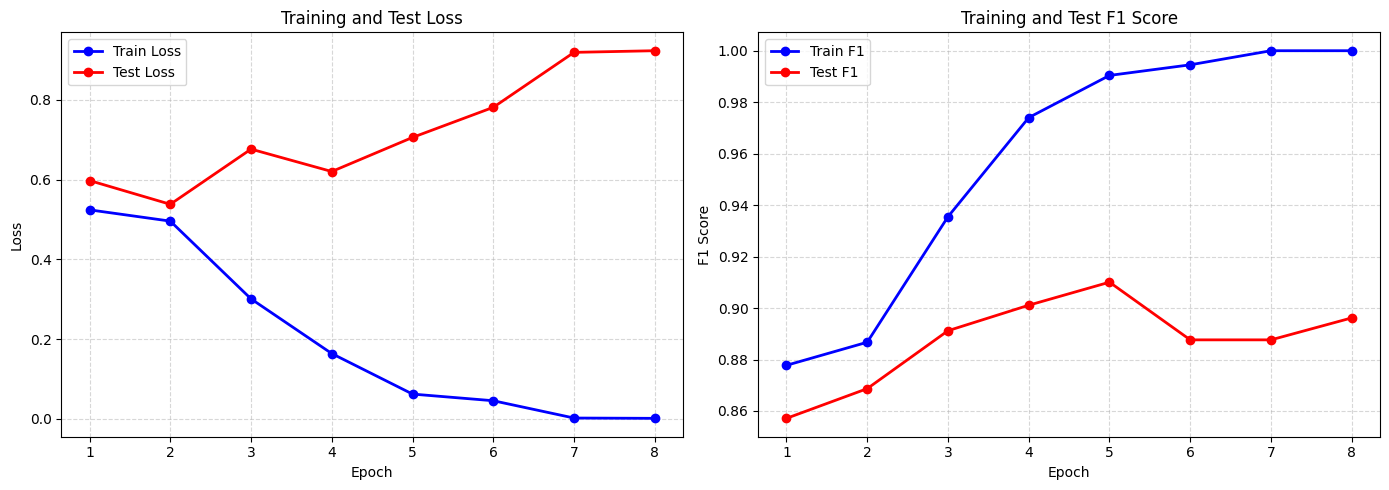

✅ Chart saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_charts.png

Confusion Matrix:
[[15 14]
 [ 5 82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61        29
           1       0.85      0.94      0.90        87

    accuracy                           0.84       116
   macro avg       0.80      0.73      0.75       116
weighted avg       0.83      0.84      0.83       116

✅ Evaluation report saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_eval.txt


In [14]:
plot_training_history_cm_cr(history_n, y_true=y_test_n, y_pred=y_test_pred_n, run_name="./final_results/StanceClassification_Bert_MT1_B4_E8")


# Train Stance  Classifier 

In [15]:
model, history, y_test_pred= train_model(
    X_train=(X_train['text'].tolist(), X_train['topic_id'].tolist(), X_train['nrc_feats'].tolist()),
    y_train=y_train.tolist(),
    X_test=(X_test['text'].tolist(), X_test['topic_id'].tolist(), X_test['nrc_feats'].tolist()),
    y_test=y_test.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 115/115 [04:26<00:00,  2.31s/it]



Epoch 1/8
Train Loss: 0.5328, Train F1: 0.8790
Test Loss: 0.5284, F1: 0.8485, Precision: 0.8077, Recall: 0.8936
--------------------------------------------------


Epoch 2/8: 100%|██████████| 115/115 [04:13<00:00,  2.20s/it]



Epoch 2/8
Train Loss: 0.4340, Train F1: 0.8993
Test Loss: 0.5723, F1: 0.8952, Precision: 0.8103, Recall: 1.0000
--------------------------------------------------


Epoch 3/8: 100%|██████████| 115/115 [04:14<00:00,  2.21s/it]



Epoch 3/8
Train Loss: 0.2875, Train F1: 0.9384
Test Loss: 0.5808, F1: 0.9216, Precision: 0.8545, Recall: 1.0000
--------------------------------------------------


Epoch 4/8: 100%|██████████| 115/115 [04:40<00:00,  2.44s/it]



Epoch 4/8
Train Loss: 0.1248, Train F1: 0.9793
Test Loss: 0.8360, F1: 0.8945, Precision: 0.8476, Recall: 0.9468
--------------------------------------------------


Epoch 5/8: 100%|██████████| 115/115 [05:07<00:00,  2.67s/it]



Epoch 5/8
Train Loss: 0.0900, Train F1: 0.9902
Test Loss: 0.9120, F1: 0.9055, Precision: 0.8505, Recall: 0.9681
--------------------------------------------------


Epoch 6/8: 100%|██████████| 115/115 [04:25<00:00,  2.31s/it]



Epoch 6/8
Train Loss: 0.0170, Train F1: 0.9986
Test Loss: 1.2556, F1: 0.8718, Precision: 0.8416, Recall: 0.9043
--------------------------------------------------


Epoch 7/8: 100%|██████████| 115/115 [04:32<00:00,  2.37s/it]



Epoch 7/8
Train Loss: 0.0288, Train F1: 0.9972
Test Loss: 1.2544, F1: 0.8808, Precision: 0.8586, Recall: 0.9043
--------------------------------------------------


Epoch 8/8: 100%|██████████| 115/115 [04:29<00:00,  2.35s/it]



Epoch 8/8
Train Loss: 0.0166, Train F1: 0.9986
Test Loss: 1.3071, F1: 0.8808, Precision: 0.8586, Recall: 0.9043
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled.pt


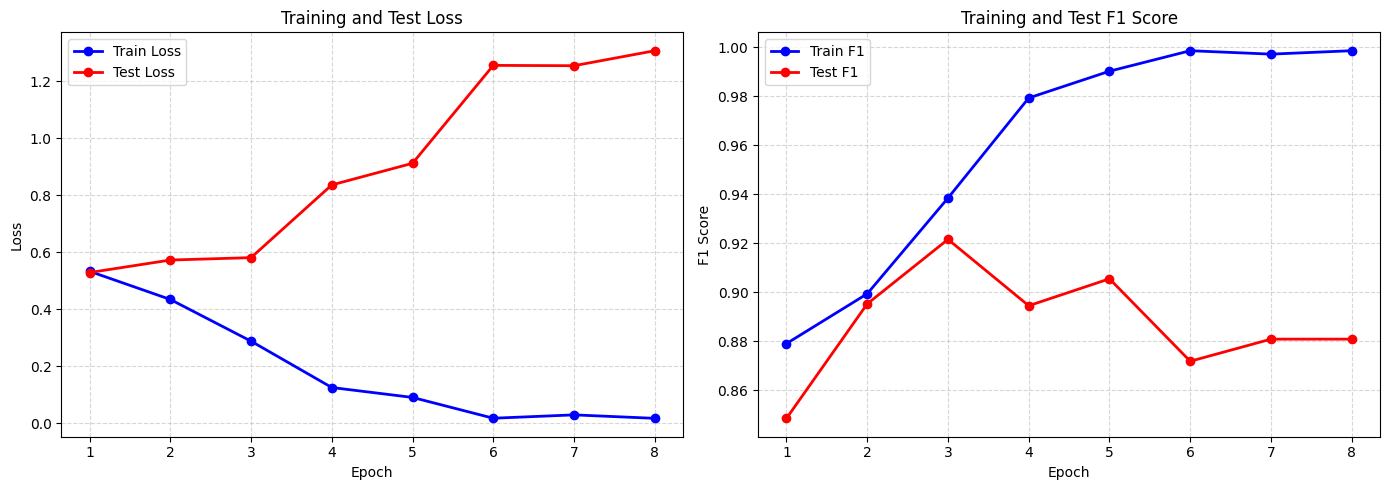

✅ Chart saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled_charts.png

Confusion Matrix:
[[11 14]
 [ 9 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49        25
           1       0.86      0.90      0.88        94

    accuracy                           0.81       119
   macro avg       0.70      0.67      0.68       119
weighted avg       0.79      0.81      0.80       119

✅ Evaluation report saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled_eval.txt


In [16]:
plot_training_history_cm_cr(history,y_true=y_test,y_pred=y_test_pred, classes=["0", "1"], run_name='./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled')


# MT2

In [4]:
X_train2, X_test2, y_train2, y_test2 = preprocess_data(dfMT2, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

In [5]:
X_train2_n, X_test2_n, y_train2_n, y_test2_n = preprocess_data(dfMT2, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [6]:
model2_n, history2_n, y_test2_pred_n = train_model(
    X_train=(X_train2_n['text'].tolist(), X_train2_n['topic_id'].tolist()),
    y_train=y_train2_n.tolist(),
    X_test=(X_test2_n['text'].tolist(), X_test2_n['topic_id'].tolist()),
    y_test=y_test2_n.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results//StanceClassification_Bert_MT2_B4_E8.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 160/160 [05:43<00:00,  2.14s/it]



Epoch 1/8
Train Loss: 0.4166, Train F1: 0.9271
Test Loss: 0.3987, F1: 0.9298, Precision: 0.8742, Recall: 0.9929
--------------------------------------------------


Epoch 2/8: 100%|██████████| 160/160 [05:17<00:00,  1.98s/it]



Epoch 2/8
Train Loss: 0.3873, Train F1: 0.9338
Test Loss: 0.3977, F1: 0.9384, Precision: 0.9013, Recall: 0.9786
--------------------------------------------------


Epoch 3/8: 100%|██████████| 160/160 [05:18<00:00,  1.99s/it]



Epoch 3/8
Train Loss: 0.2911, Train F1: 0.9572
Test Loss: 0.5047, F1: 0.9288, Precision: 0.8839, Recall: 0.9786
--------------------------------------------------


Epoch 4/8: 100%|██████████| 160/160 [05:19<00:00,  2.00s/it]



Epoch 4/8
Train Loss: 0.2056, Train F1: 0.9716
Test Loss: 0.7719, F1: 0.9046, Precision: 0.8951, Recall: 0.9143
--------------------------------------------------


Epoch 5/8: 100%|██████████| 160/160 [05:19<00:00,  2.00s/it]



Epoch 5/8
Train Loss: 0.1424, Train F1: 0.9829
Test Loss: 0.7517, F1: 0.9199, Precision: 0.8980, Recall: 0.9429
--------------------------------------------------


Epoch 6/8: 100%|██████████| 160/160 [05:18<00:00,  1.99s/it]



Epoch 6/8
Train Loss: 0.0978, Train F1: 0.9883
Test Loss: 0.7856, F1: 0.9204, Precision: 0.8926, Recall: 0.9500
--------------------------------------------------


Epoch 7/8: 100%|██████████| 160/160 [06:10<00:00,  2.32s/it]



Epoch 7/8
Train Loss: 0.0629, Train F1: 0.9927
Test Loss: 0.9458, F1: 0.9078, Precision: 0.9014, Recall: 0.9143
--------------------------------------------------


Epoch 8/8: 100%|██████████| 160/160 [06:08<00:00,  2.30s/it]



Epoch 8/8
Train Loss: 0.0425, Train F1: 0.9955
Test Loss: 0.9772, F1: 0.9097, Precision: 0.8851, Recall: 0.9357
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results//StanceClassification_Bert_MT2_B4_E8.pt


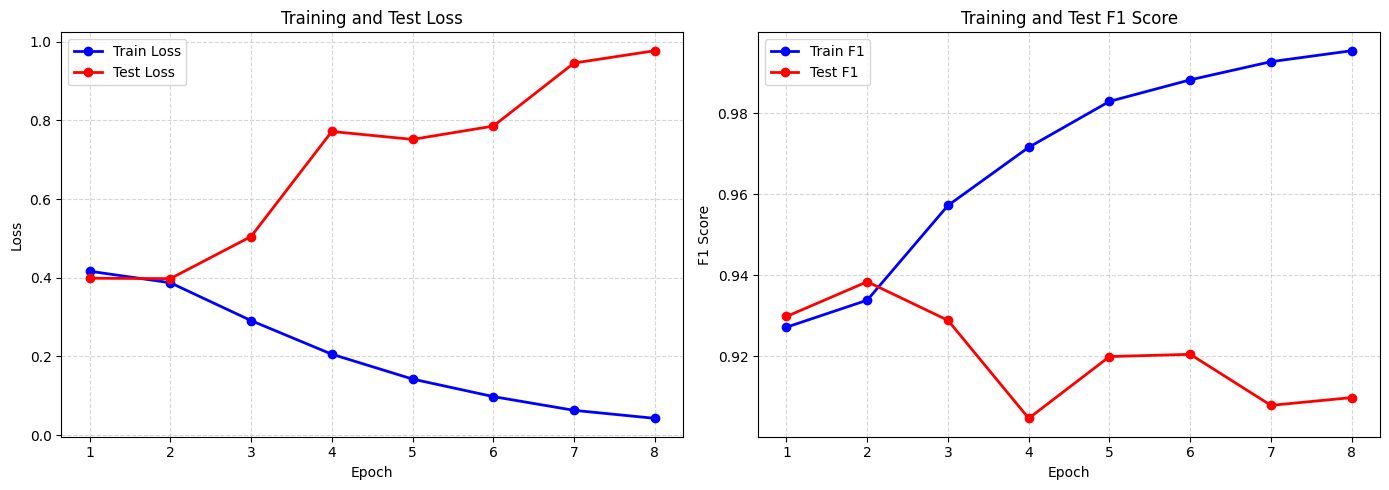

✅ Chart saved as ./final_results//StanceClassification_Bert_MT2_B4_E8_charts.png

Confusion Matrix:
[[  3  17]
 [  9 131]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.15      0.19        20
           1       0.89      0.94      0.91       140

    accuracy                           0.84       160
   macro avg       0.57      0.54      0.55       160
weighted avg       0.81      0.84      0.82       160

✅ Evaluation report saved as ./final_results//StanceClassification_Bert_MT2_B4_E8_eval.txt


In [7]:
plot_training_history_cm_cr(history2_n, y_true=y_test2_n, y_pred=y_test2_pred_n, run_name="./final_results//StanceClassification_Bert_MT2_B4_E8")


In [8]:
model2, history2, y_test2_pred= train_model(
    X_train=(X_train2['text'].tolist(), X_train2['topic_id'].tolist(), X_train2['nrc_feats'].tolist()),
    y_train=y_train2.tolist(),
    X_test=(X_test2['text'].tolist(), X_test2['topic_id'].tolist(), X_test2['nrc_feats'].tolist()),
    y_test=y_test2.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results//StanceClassification_Bert_MT2_B4_E8_Sampled.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 160/160 [05:40<00:00,  2.13s/it]



Epoch 1/8
Train Loss: 0.4491, Train F1: 0.9217
Test Loss: 0.3661, F1: 0.9435, Precision: 0.8931, Recall: 1.0000
--------------------------------------------------


Epoch 2/8: 100%|██████████| 160/160 [05:32<00:00,  2.08s/it]



Epoch 2/8
Train Loss: 0.4132, Train F1: 0.9331
Test Loss: 0.3831, F1: 0.9338, Precision: 0.9241, Recall: 0.9437
--------------------------------------------------


Epoch 3/8: 100%|██████████| 160/160 [05:34<00:00,  2.09s/it]



Epoch 3/8
Train Loss: 0.3860, Train F1: 0.9426
Test Loss: 0.3887, F1: 0.9424, Precision: 0.9085, Recall: 0.9789
--------------------------------------------------


Epoch 4/8: 100%|██████████| 160/160 [05:34<00:00,  2.09s/it]



Epoch 4/8
Train Loss: 0.3196, Train F1: 0.9482
Test Loss: 0.4210, F1: 0.9495, Precision: 0.9097, Recall: 0.9930
--------------------------------------------------


Epoch 5/8: 100%|██████████| 160/160 [05:34<00:00,  2.09s/it]



Epoch 5/8
Train Loss: 0.2226, Train F1: 0.9626
Test Loss: 0.5458, F1: 0.9384, Precision: 0.9133, Recall: 0.9648
--------------------------------------------------


Epoch 6/8: 100%|██████████| 160/160 [05:35<00:00,  2.10s/it]



Epoch 6/8
Train Loss: 0.1167, Train F1: 0.9837
Test Loss: 0.6423, F1: 0.9338, Precision: 0.9241, Recall: 0.9437
--------------------------------------------------


Epoch 7/8: 100%|██████████| 160/160 [05:35<00:00,  2.10s/it]



Epoch 7/8
Train Loss: 0.0703, Train F1: 0.9909
Test Loss: 0.6583, F1: 0.9338, Precision: 0.9241, Recall: 0.9437
--------------------------------------------------


Epoch 8/8: 100%|██████████| 160/160 [05:34<00:00,  2.09s/it]



Epoch 8/8
Train Loss: 0.0467, Train F1: 0.9954
Test Loss: 0.7688, F1: 0.9214, Precision: 0.9348, Recall: 0.9085
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results//StanceClassification_Bert_MT2_B4_E8_Sampled.pt


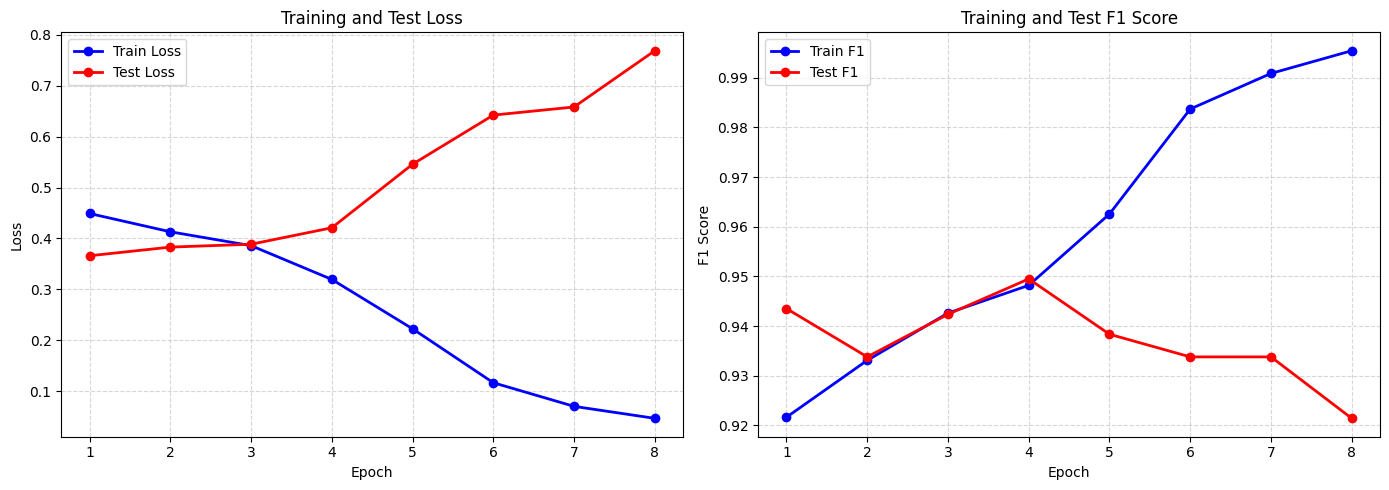

✅ Chart saved as ./final_results//StanceClassification_Bert_MT2_B4_E8_Sampled_charts.png

Confusion Matrix:
[[  8   9]
 [ 13 129]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.47      0.42        17
           1       0.93      0.91      0.92       142

    accuracy                           0.86       159
   macro avg       0.66      0.69      0.67       159
weighted avg       0.88      0.86      0.87       159

✅ Evaluation report saved as ./final_results//StanceClassification_Bert_MT2_B4_E8_Sampled_eval.txt


In [9]:
plot_training_history_cm_cr(history2, y_true=y_test2,y_pred=y_test2_pred, classes=["0", "1"], run_name='./final_results//StanceClassification_Bert_MT2_B4_E8_Sampled')


# IBM

In [10]:
X_train3, X_test3, y_train3, y_test3 = preprocess_data(dfIBM, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

In [11]:
X_train3_n, X_test3_n, y_train3_n, y_test3_n = preprocess_data(dfIBM, use_nrc=  False, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [12]:
model3_n, history3_n, y_test3_pred_n = train_model(
    X_train=(X_train3_n['text'].tolist(), X_train3_n['topic_id'].tolist()),
    y_train=y_train3_n.tolist(),
    X_test=(X_test3_n['text'].tolist(), X_test3_n['topic_id'].tolist()),
    y_test=y_test3_n.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results//StanceClassification_Bert_IBM_B4_E8.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 479/479 [17:09<00:00,  2.15s/it]



Epoch 1/8
Train Loss: 0.6789, Train F1: 0.6791
Test Loss: 0.6599, F1: 0.7116, Precision: 0.6086, Recall: 0.8566
--------------------------------------------------


Epoch 2/8: 100%|██████████| 479/479 [15:45<00:00,  1.97s/it]



Epoch 2/8
Train Loss: 0.5771, Train F1: 0.7611
Test Loss: 0.7754, F1: 0.7324, Precision: 0.6257, Recall: 0.8830
--------------------------------------------------


Epoch 3/8: 100%|██████████| 479/479 [17:34<00:00,  2.20s/it]



Epoch 3/8
Train Loss: 0.4321, Train F1: 0.8752
Test Loss: 1.2074, F1: 0.7363, Precision: 0.6740, Recall: 0.8113
--------------------------------------------------


Epoch 4/8: 100%|██████████| 479/479 [16:27<00:00,  2.06s/it]



Epoch 4/8
Train Loss: 0.2695, Train F1: 0.9400
Test Loss: 1.3836, F1: 0.6831, Precision: 0.7511, Recall: 0.6264
--------------------------------------------------


Epoch 5/8: 100%|██████████| 479/479 [15:41<00:00,  1.96s/it]



Epoch 5/8
Train Loss: 0.1502, Train F1: 0.9707
Test Loss: 1.8553, F1: 0.7241, Precision: 0.6667, Recall: 0.7925
--------------------------------------------------


Epoch 6/8: 100%|██████████| 479/479 [14:27<00:00,  1.81s/it]



Epoch 6/8
Train Loss: 0.0813, Train F1: 0.9854
Test Loss: 1.7292, F1: 0.7604, Precision: 0.7042, Recall: 0.8264
--------------------------------------------------


Epoch 7/8: 100%|██████████| 479/479 [14:18<00:00,  1.79s/it]



Epoch 7/8
Train Loss: 0.0321, Train F1: 0.9948
Test Loss: 2.2954, F1: 0.7554, Precision: 0.6404, Recall: 0.9208
--------------------------------------------------


Epoch 8/8: 100%|██████████| 479/479 [14:36<00:00,  1.83s/it]



Epoch 8/8
Train Loss: 0.0496, Train F1: 0.9911
Test Loss: 2.1887, F1: 0.7534, Precision: 0.6820, Recall: 0.8415
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results//StanceClassification_Bert_IBM_B4_E8.pt


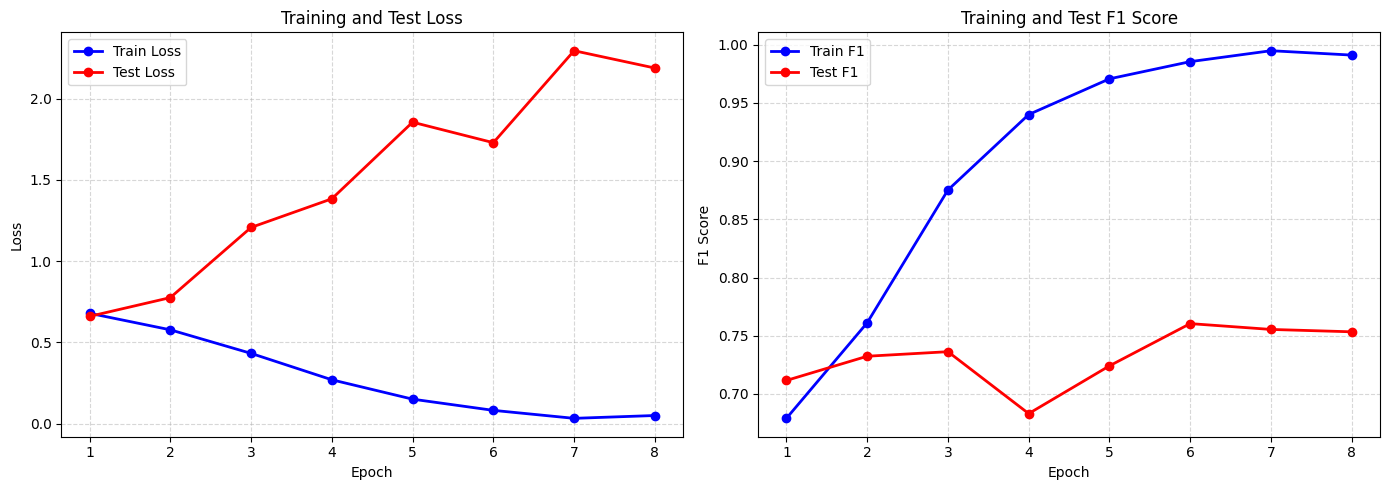

✅ Chart saved as ./final_results//StanceClassification_Bert_IBM_B4_E8_charts.png

Confusion Matrix:
[[110 104]
 [ 42 223]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.51      0.60       214
           1       0.68      0.84      0.75       265

    accuracy                           0.70       479
   macro avg       0.70      0.68      0.68       479
weighted avg       0.70      0.70      0.69       479

✅ Evaluation report saved as ./final_results//StanceClassification_Bert_IBM_B4_E8_eval.txt


In [13]:
plot_training_history_cm_cr(history3_n, y_true=y_test3_n, y_pred=y_test3_pred_n, run_name="./final_results//StanceClassification_Bert_IBM_B4_E8")


In [17]:
model3, history3, y_test3_pred= train_model(
    X_train=(X_train3['text'].tolist(), X_train3['topic_id'].tolist(), X_train3['nrc_feats'].tolist()),
    y_train=y_train3.tolist(),
    X_test=(X_test3['text'].tolist(), X_test3['topic_id'].tolist(), X_test3['nrc_feats'].tolist()),
    y_test=y_test3.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results//StanceClassification_Bert_IBM_B4_E8.Sampled.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 460/460 [21:51<00:00,  2.85s/it]



Epoch 1/8
Train Loss: 0.6698, Train F1: 0.6626
Test Loss: 0.7161, F1: 0.5846, Precision: 0.6333, Recall: 0.5429
--------------------------------------------------


Epoch 2/8: 100%|██████████| 460/460 [19:08<00:00,  2.50s/it]



Epoch 2/8
Train Loss: 0.5311, Train F1: 0.7872
Test Loss: 1.0543, F1: 0.5963, Precision: 0.5752, Recall: 0.6190
--------------------------------------------------


Epoch 3/8: 100%|██████████| 460/460 [17:16<00:00,  2.25s/it]



Epoch 3/8
Train Loss: 0.3620, Train F1: 0.9101
Test Loss: 1.5786, F1: 0.6927, Precision: 0.6019, Recall: 0.8159
--------------------------------------------------


Epoch 4/8: 100%|██████████| 460/460 [16:40<00:00,  2.17s/it]



Epoch 4/8
Train Loss: 0.2393, Train F1: 0.9493
Test Loss: 2.3866, F1: 0.5568, Precision: 0.5613, Recall: 0.5524
--------------------------------------------------


Epoch 5/8: 100%|██████████| 460/460 [16:26<00:00,  2.14s/it]



Epoch 5/8
Train Loss: 0.1182, Train F1: 0.9778
Test Loss: 2.8334, F1: 0.4492, Precision: 0.5838, Recall: 0.3651
--------------------------------------------------


Epoch 6/8: 100%|██████████| 460/460 [15:39<00:00,  2.04s/it]



Epoch 6/8
Train Loss: 0.0772, Train F1: 0.9866
Test Loss: 3.3174, F1: 0.4664, Precision: 0.5656, Recall: 0.3968
--------------------------------------------------


Epoch 7/8: 100%|██████████| 460/460 [15:36<00:00,  2.04s/it]



Epoch 7/8
Train Loss: 0.0548, Train F1: 0.9911
Test Loss: 3.5454, F1: 0.4364, Precision: 0.6000, Recall: 0.3429
--------------------------------------------------


Epoch 8/8: 100%|██████████| 460/460 [15:32<00:00,  2.03s/it]



Epoch 8/8
Train Loss: 0.0536, Train F1: 0.9926
Test Loss: 3.7852, F1: 0.4332, Precision: 0.5978, Recall: 0.3397
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results//StanceClassification_Bert_IBM_B4_E8.Sampled.pt


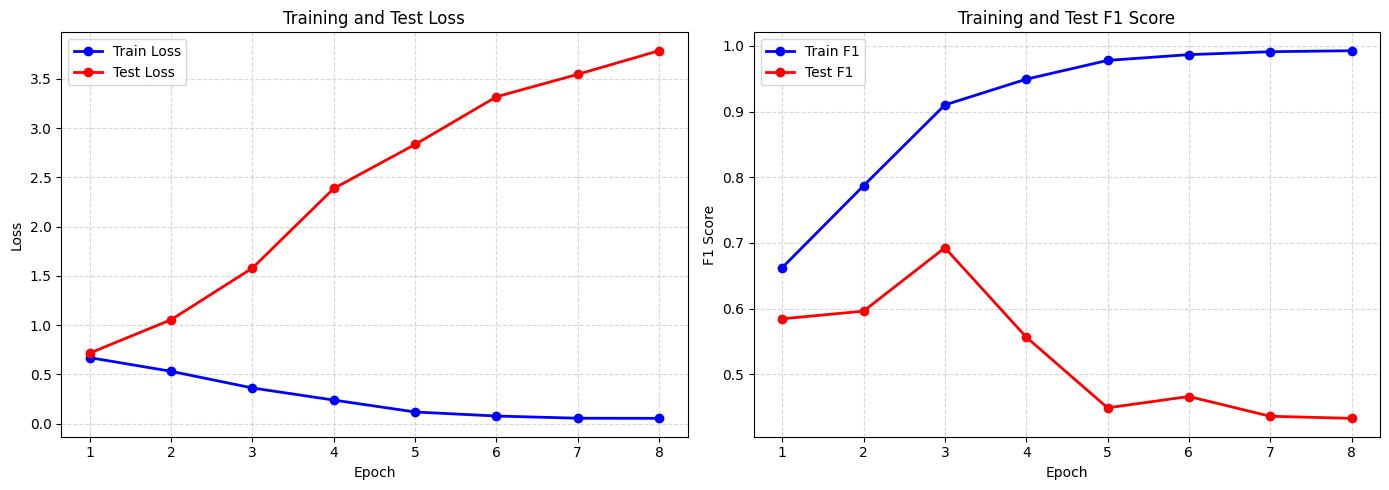

✅ Chart saved as ./final_results//StanceClassification_Bert_IBM_B4_E8.Sampled_charts.png

Confusion Matrix:
[[170  72]
 [208 107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.70      0.55       242
           1       0.60      0.34      0.43       315

    accuracy                           0.50       557
   macro avg       0.52      0.52      0.49       557
weighted avg       0.53      0.50      0.48       557

✅ Evaluation report saved as ./final_results//StanceClassification_Bert_IBM_B4_E8.Sampled_eval.txt


In [18]:
plot_training_history_cm_cr(history3, y_true=y_test3,y_pred=y_test3_pred, classes=["0", "1"], run_name='./final_results//StanceClassification_Bert_IBM_B4_E8.Sampled')


# PE

In [19]:
dfPC['stance'] = dfPC['stance'].apply(
    lambda stance_list: ['Neutral' if s is None else s for s in stance_list]
)

In [22]:
X_train4, X_test4, y_train4, y_test4 = preprocess_data(dfPC, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41)

In [23]:
X_train4_n, X_test4_n, y_train4_n, y_test4_n = preprocess_data(dfPC, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [24]:
model4, history4, y_test4_pred= train_model(
    X_train=(X_train4['text'].tolist(), X_train4['topic_id'].tolist(), X_train4['nrc_feats'].tolist()),
    y_train=y_train4.tolist(),
    X_test=(X_test4['text'].tolist(), X_test4['topic_id'].tolist(), X_test4['nrc_feats'].tolist()),
    y_test=y_test4.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results//StanceClassification_Bert_PE_B4_E8.pt'
)



h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 1218/1218 [43:08<00:00,  2.13s/it]



Epoch 1/8
Train Loss: 0.6901, Train F1: 0.2966
Test Loss: 0.6382, F1: 0.2853, Precision: 0.2494, Recall: 0.3333
--------------------------------------------------


Epoch 2/8: 100%|██████████| 1218/1218 [45:13<00:00,  2.23s/it]



Epoch 2/8
Train Loss: 0.6510, Train F1: 0.3921
Test Loss: 0.7591, F1: 0.3669, Precision: 0.3993, Recall: 0.3738
--------------------------------------------------


Epoch 3/8: 100%|██████████| 1218/1218 [44:00<00:00,  2.17s/it]



Epoch 3/8
Train Loss: 0.5264, Train F1: 0.5790
Test Loss: 1.1578, F1: 0.4706, Precision: 0.5414, Recall: 0.4473
--------------------------------------------------


Epoch 4/8: 100%|██████████| 1218/1218 [42:57<00:00,  2.12s/it]



Epoch 4/8
Train Loss: 0.3805, Train F1: 0.7226
Test Loss: 1.5244, F1: 0.4126, Precision: 0.5239, Recall: 0.4036
--------------------------------------------------


Epoch 5/8: 100%|██████████| 1218/1218 [42:45<00:00,  2.11s/it]



Epoch 5/8
Train Loss: 0.2758, Train F1: 0.8250
Test Loss: 1.6702, F1: 0.4061, Precision: 0.4881, Recall: 0.4000
--------------------------------------------------


Epoch 6/8: 100%|██████████| 1218/1218 [44:13<00:00,  2.18s/it]



Epoch 6/8
Train Loss: 0.1777, Train F1: 0.8913
Test Loss: 2.2176, F1: 0.3966, Precision: 0.4372, Recall: 0.4130
--------------------------------------------------


Epoch 7/8: 100%|██████████| 1218/1218 [42:50<00:00,  2.11s/it]



Epoch 7/8
Train Loss: 0.1282, Train F1: 0.9363
Test Loss: 2.2029, F1: 0.4439, Precision: 0.5317, Recall: 0.4284
--------------------------------------------------


Epoch 8/8: 100%|██████████| 1218/1218 [42:47<00:00,  2.11s/it]



Epoch 8/8
Train Loss: 0.0818, Train F1: 0.9662
Test Loss: 2.5213, F1: 0.4723, Precision: 0.4674, Recall: 0.4780
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results//StanceClassification_Bert_PE_B4_E8.pt


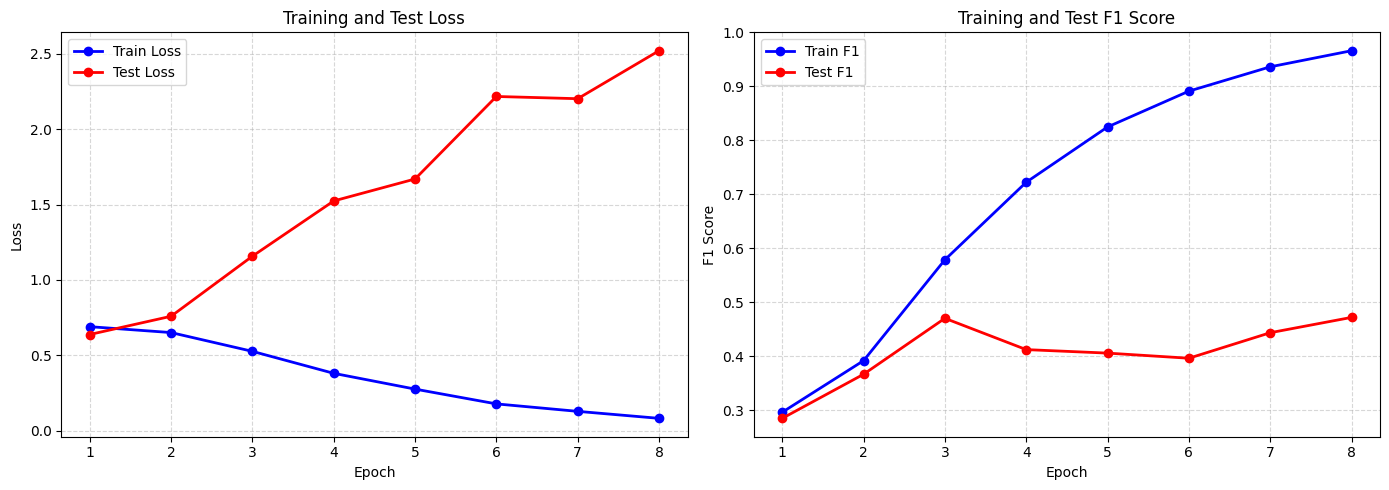

✅ Chart saved as ./final_results//StanceClassification_Bert_PE_B4_E8.pt_charts.png

Confusion Matrix:
[[ 13  10  24]
 [ 17  94 150]
 [ 24 161 727]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.28      0.26        47
           1       0.35      0.36      0.36       261
           2       0.81      0.80      0.80       912

    accuracy                           0.68      1220
   macro avg       0.47      0.48      0.47      1220
weighted avg       0.69      0.68      0.69      1220

✅ Evaluation report saved as ./final_results//StanceClassification_Bert_PE_B4_E8.pt_eval.txt


In [25]:
plot_training_history_cm_cr(history4, y_true=y_test4, y_pred=y_test4_pred, classes=["0", "1", "2"], run_name='./final_results//StanceClassification_Bert_PE_B4_E8.pt')


In [28]:
model4_n, history4_n, y_test4_pred_n = train_model(
    X_train=(X_train4_n['text'].tolist(), X_train4_n['topic_id'].tolist()),
    y_train=y_train4_n.tolist(),
    X_test=(X_test4_n['text'].tolist(), X_test4_n['topic_id'].tolist()),
    y_test=y_test4_n.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results/StanceClassification_Bert_PE_B4_E8_Sampled.pt'
    )




Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 1218/1218 [54:20<00:00,  2.68s/it] 



Epoch 1/8
Train Loss: 0.6988, Train F1: 0.2924
Test Loss: 0.6780, F1: 0.2847, Precision: 0.2485, Recall: 0.3333
--------------------------------------------------


Epoch 2/8: 100%|██████████| 1218/1218 [51:29<00:00,  2.54s/it]



Epoch 2/8
Train Loss: 0.6763, Train F1: 0.3169
Test Loss: 0.7726, F1: 0.2921, Precision: 0.3492, Recall: 0.3354
--------------------------------------------------


Epoch 3/8: 100%|██████████| 1218/1218 [50:21<00:00,  2.48s/it]



Epoch 3/8
Train Loss: 0.6458, Train F1: 0.4439
Test Loss: 0.6891, F1: 0.3514, Precision: 0.3630, Recall: 0.3608
--------------------------------------------------


Epoch 4/8: 100%|██████████| 1218/1218 [48:01<00:00,  2.37s/it]



Epoch 4/8
Train Loss: 0.5460, Train F1: 0.5568
Test Loss: 1.1002, F1: 0.4012, Precision: 0.4761, Recall: 0.3960
--------------------------------------------------


Epoch 5/8: 100%|██████████| 1218/1218 [48:26<00:00,  2.39s/it] 



Epoch 5/8
Train Loss: 0.4335, Train F1: 0.6727
Test Loss: 1.5321, F1: 0.4119, Precision: 0.4562, Recall: 0.4004
--------------------------------------------------


Epoch 6/8: 100%|██████████| 1218/1218 [1:05:28<00:00,  3.23s/it]



Epoch 6/8
Train Loss: 0.3321, Train F1: 0.7629
Test Loss: 1.5679, F1: 0.4105, Precision: 0.4406, Recall: 0.4030
--------------------------------------------------


Epoch 7/8: 100%|██████████| 1218/1218 [49:55<00:00,  2.46s/it]



Epoch 7/8
Train Loss: 0.2652, Train F1: 0.8099
Test Loss: 1.6939, F1: 0.4178, Precision: 0.4189, Recall: 0.4173
--------------------------------------------------


Epoch 8/8: 100%|██████████| 1218/1218 [44:54<00:00,  2.21s/it]



Epoch 8/8
Train Loss: 0.2192, Train F1: 0.8460
Test Loss: 1.9498, F1: 0.4280, Precision: 0.4333, Recall: 0.4241
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/StanceClassification_Bert_PE_B4_E8_Sampled.pt


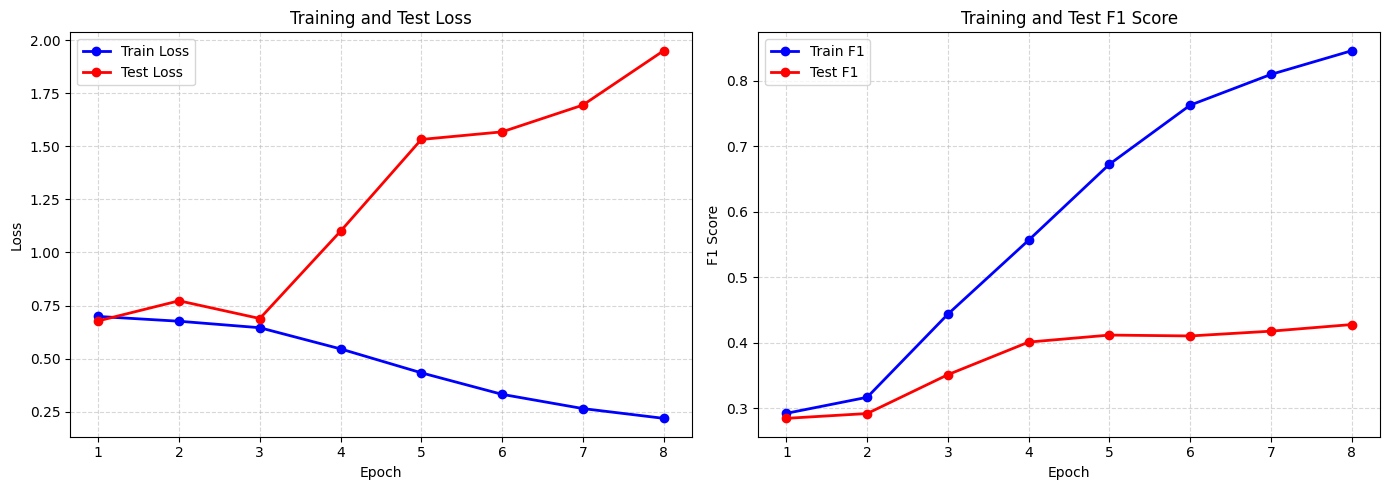

✅ Chart saved as ./final_results//StanceClassification_Bert_PE_B4_E8_Sampled.pt_charts.png

Confusion Matrix:
[[  6  14  36]
 [ 14  87 153]
 [ 24 137 747]]

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.11      0.12        56
           1       0.37      0.34      0.35       254
           2       0.80      0.82      0.81       908

    accuracy                           0.69      1218
   macro avg       0.43      0.42      0.43      1218
weighted avg       0.68      0.69      0.68      1218

✅ Evaluation report saved as ./final_results//StanceClassification_Bert_PE_B4_E8_Sampled.pt_eval.txt


In [29]:
plot_training_history_cm_cr(history4_n, y_true=y_test4_n, y_pred=y_test4_pred_n,classes=["0", "1", "2"], run_name='./final_results//StanceClassification_Bert_PE_B4_E8_Sampled.pt')


# UKP

In [31]:
dfUKB['stance'] = dfUKB['stance'].apply(
    lambda stance_list: ['Neutral' if s is None else s for s in stance_list]
)

In [32]:
X_train5, X_test5, y_train5, y_test5 = preprocess_data(dfUKB, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41)

In [42]:
X_train5_n, X_test5_n, y_train5_n, y_test5_n = preprocess_data(dfUKB[0:5], use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

h:\moha\NLP\AM\SA\ArguSentiment\src\data_preprocess_stance.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_id'] = df['topic_id'].fillna('Unknown')


In [39]:
model5, history5, y_test5_pred= train_model(
    X_train=(X_train5['text'].tolist(), X_train5['topic_id'].tolist(), X_train5['nrc_feats'].tolist()),
    y_train=y_train5.tolist(),
    X_test=(X_test5['text'].tolist(), X_test5['topic_id'].tolist(), X_test5['nrc_feats'].tolist()),
    y_test=y_test5.tolist(),
    batch_size=4,
    epochs=4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results/StanceClassification_Bert_UKP_B4_E4.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/4: 100%|██████████| 4841/4841 [2:53:13<00:00,  2.15s/it]  



Epoch 1/4
Train Loss: 0.7743, Train F1: 0.5642
Test Loss: 1.1308, F1: 0.4642, Precision: 0.6531, Recall: 0.4577
--------------------------------------------------


Epoch 2/4: 100%|██████████| 4841/4841 [2:45:37<00:00,  2.05s/it]  



Epoch 2/4
Train Loss: 0.6106, Train F1: 0.7321
Test Loss: 1.6883, F1: 0.4067, Precision: 0.6162, Recall: 0.4182
--------------------------------------------------


Epoch 3/4: 100%|██████████| 4841/4841 [2:43:56<00:00,  2.03s/it]  



Epoch 3/4
Train Loss: 0.4936, Train F1: 0.8311
Test Loss: 1.9923, F1: 0.4959, Precision: 0.6336, Recall: 0.4826
--------------------------------------------------


Epoch 4/4: 100%|██████████| 4841/4841 [2:45:04<00:00,  2.05s/it]  



Epoch 4/4
Train Loss: 0.3703, Train F1: 0.8917
Test Loss: 2.6554, F1: 0.3773, Precision: 0.5142, Recall: 0.3949
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/StanceClassification_Bert_UKP_B4_E4.pt


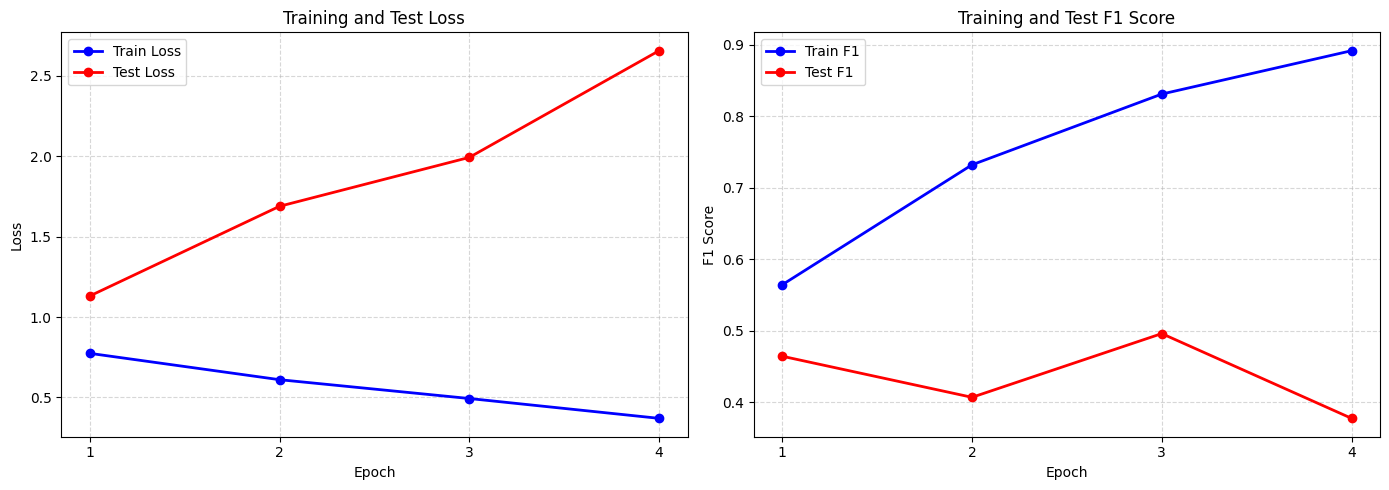

✅ Chart saved as ./final_results/StanceClassification_Bert_UKP_B4_E4_charts.png

Confusion Matrix:
[[ 176  142 1085]
 [  24  158 1000]
 [  96  162 3206]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.13      0.21      1403
           1       0.34      0.13      0.19      1182
           2       0.61      0.93      0.73      3464

    accuracy                           0.59      6049
   macro avg       0.51      0.39      0.38      6049
weighted avg       0.55      0.59      0.51      6049

✅ Evaluation report saved as ./final_results/StanceClassification_Bert_UKP_B4_E4_eval.txt


In [40]:
plot_training_history_cm_cr(history5, y_true=y_test5, y_pred=y_test5_pred, classes=["0", "1", "2"], run_name='./final_results/StanceClassification_Bert_UKP_B4_E4')


In [44]:
model5_n, history5_n, y_test5_pred_n = train_model(
    X_train=(X_train5_n['text'].tolist(), X_train5_n['topic_id'].tolist()),
    y_train=y_train5_n.tolist(),
    X_test=(X_test5_n['text'].tolist(), X_test5_n['topic_id'].tolist()),
    y_test=y_test5_n.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results/StanceClassification_Bert_UKP_B4_E4_Sampled.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 3287/3287 [1:57:38<00:00,  2.15s/it]



Epoch 1/8
Train Loss: 0.8099, Train F1: 0.5245
Test Loss: 0.6967, F1: 0.6140, Precision: 0.6199, Recall: 0.6139
--------------------------------------------------


Epoch 2/8: 100%|██████████| 3287/3287 [1:57:49<00:00,  2.15s/it]



Epoch 2/8
Train Loss: 0.6311, Train F1: 0.6942
Test Loss: 0.8314, F1: 0.6523, Precision: 0.6625, Recall: 0.6575
--------------------------------------------------


Epoch 3/8: 100%|██████████| 3287/3287 [1:57:44<00:00,  2.15s/it]



Epoch 3/8
Train Loss: 0.5064, Train F1: 0.8135
Test Loss: 1.0200, F1: 0.6535, Precision: 0.6676, Recall: 0.6602
--------------------------------------------------


Epoch 4/8: 100%|██████████| 3287/3287 [1:57:05<00:00,  2.14s/it]



Epoch 4/8
Train Loss: 0.3910, Train F1: 0.8822
Test Loss: 1.4990, F1: 0.6335, Precision: 0.6684, Recall: 0.6273
--------------------------------------------------


Epoch 5/8: 100%|██████████| 3287/3287 [1:56:41<00:00,  2.13s/it]



Epoch 5/8
Train Loss: 0.2983, Train F1: 0.9207
Test Loss: 1.4552, F1: 0.6655, Precision: 0.6647, Recall: 0.6716
--------------------------------------------------


Epoch 6/8: 100%|██████████| 3287/3287 [1:57:19<00:00,  2.14s/it]



Epoch 6/8
Train Loss: 0.2225, Train F1: 0.9478
Test Loss: 1.7588, F1: 0.6455, Precision: 0.6444, Recall: 0.6558
--------------------------------------------------


Epoch 7/8: 100%|██████████| 3287/3287 [1:55:03<00:00,  2.10s/it]



Epoch 7/8
Train Loss: 0.1907, Train F1: 0.9531
Test Loss: 1.8582, F1: 0.6497, Precision: 0.6518, Recall: 0.6493
--------------------------------------------------


Epoch 8/8: 100%|██████████| 3287/3287 [1:55:20<00:00,  2.11s/it]



Epoch 8/8
Train Loss: 0.1479, Train F1: 0.9651
Test Loss: 2.0750, F1: 0.6530, Precision: 0.6518, Recall: 0.6632
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/StanceClassification_Bert_UKP_B4_E4_Sampled.pt


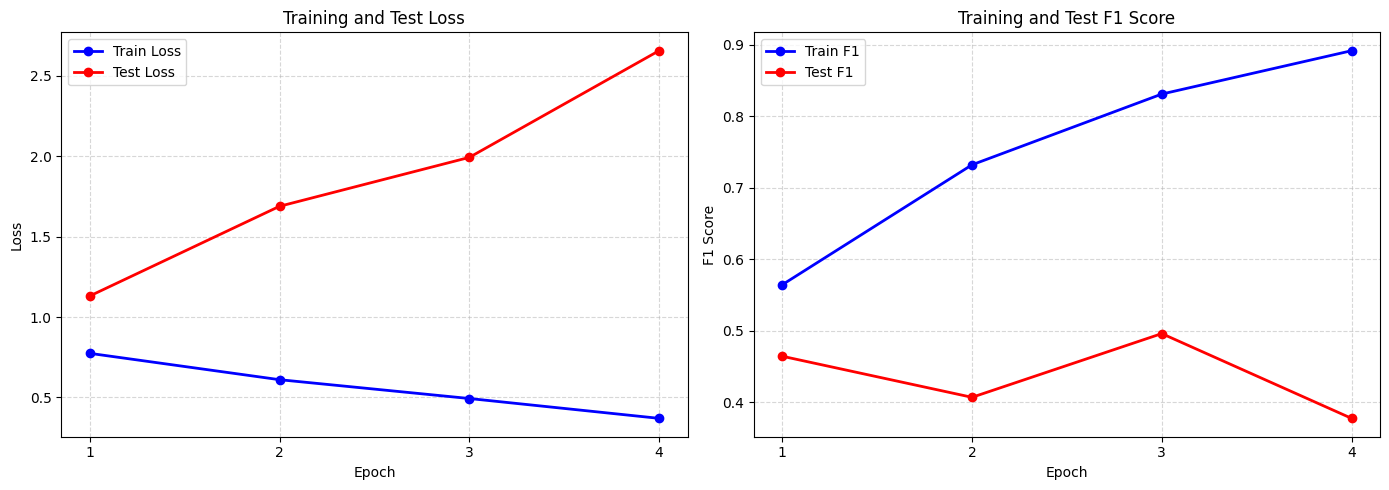

✅ Chart saved as ./final_results/StanceClassification_Bert_UKP_B4_E4_Sampled_charts.png

Confusion Matrix:
[[ 176  142 1085]
 [  24  158 1000]
 [  96  162 3206]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.13      0.21      1403
           1       0.34      0.13      0.19      1182
           2       0.61      0.93      0.73      3464

    accuracy                           0.59      6049
   macro avg       0.51      0.39      0.38      6049
weighted avg       0.55      0.59      0.51      6049

✅ Evaluation report saved as ./final_results/StanceClassification_Bert_UKP_B4_E4_Sampled_eval.txt


In [45]:
plot_training_history_cm_cr(history5, y_true=y_test5, y_pred=y_test5_pred, classes=["0", "1", "2"], run_name='./final_results/StanceClassification_Bert_UKP_B4_E4_Sampled')


# Test Reproducabilty of  the results


- MT1,2 both cases (Sample, NotSample), worked. ✅
- PE  worked,(Sample, NotvSample) ✅
- IBM (sample worked, not smaple ) ✅
- UKB (sample worked. )

In [8]:
history_n, y_test_n, y_test_pred_n = load_training_results("./models/Bert_stance_MT1_B4_E8.pt")


h:\moha\NLP\AM\SA\ArguSentiment\src\eval_stance.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location="cpu")  # or "cuda" if needed

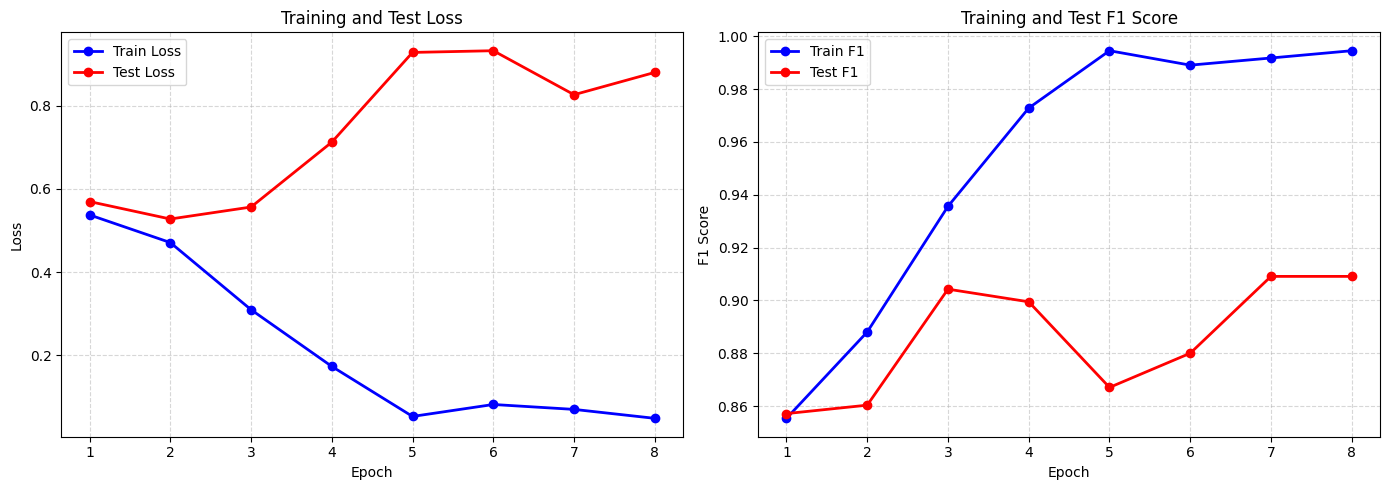

✅ Chart saved as ./models/Bert_stance_MT1_B4_E8_charts.png

Confusion Matrix:
[[14 15]
 [ 2 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62        29
           1       0.85      0.98      0.91        87

    accuracy                           0.85       116
   macro avg       0.86      0.73      0.77       116
weighted avg       0.86      0.85      0.84       116

✅ Evaluation report saved as ./models/Bert_stance_MT1_B4_E8_eval.txt


In [9]:
plot_training_history_cm_cr(
    history_n,
    y_true=y_test_n,
    y_pred=y_test_pred_n,
    run_name="./models/Bert_stance_MT1_B4_E8"
)

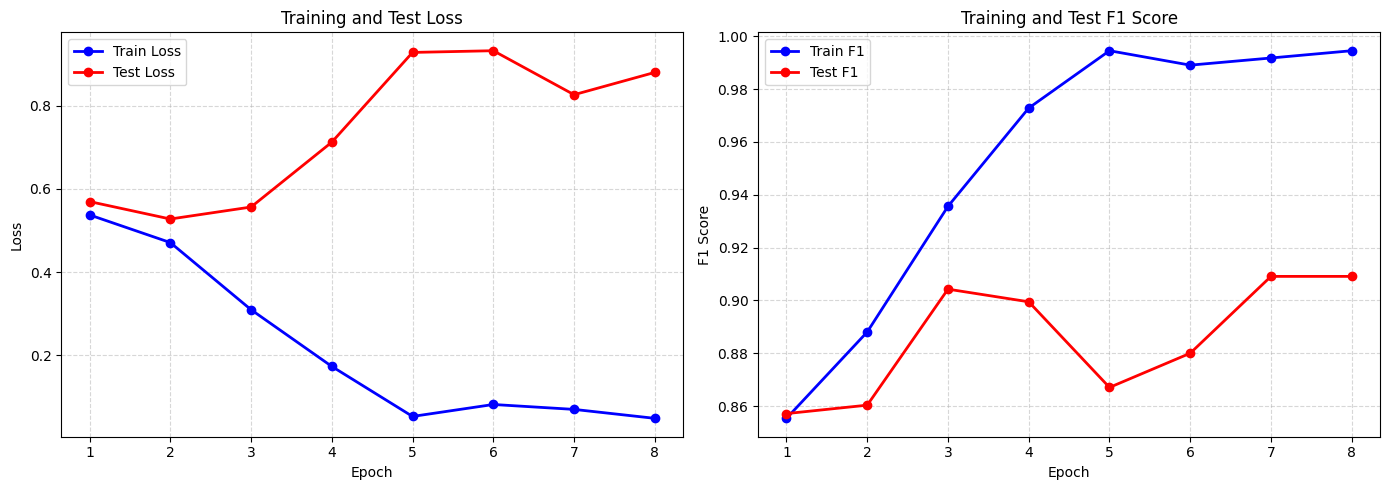

✅ Chart saved as ./models/Bert_stance_MT1_B4_E8_charts.png

Confusion Matrix:
[[14 15]
 [ 2 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62        29
           1       0.85      0.98      0.91        87

    accuracy                           0.85       116
   macro avg       0.86      0.73      0.77       116
weighted avg       0.86      0.85      0.84       116

✅ Evaluation report saved as ./models/Bert_stance_MT1_B4_E8_eval.txt


In [10]:
plot_training_history_cm_cr(
    history_n,
    y_true=y_test_n,
    y_pred=y_test_pred_n,
    run_name="./models/Bert_stance_MT1_B4_E8"
)

### Test the new reproducable code 

In [34]:
X_train, X_test, y_train, y_test = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

In [35]:
model, history, y_test_pred= train_model(
    X_train=(X_train['text'].tolist(), X_train['topic_id'].tolist(), X_train['nrc_feats'].tolist()),
    y_train=y_train.tolist(),
    X_test=(X_test['text'].tolist(), X_test['topic_id'].tolist(), X_test['nrc_feats'].tolist()),
    y_test=y_test.tolist(),
    batch_size=4,
    epochs=2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='stance_model_sampleMT1_Bert_E8_B4_solveSample.pt'
)


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/2: 100%|██████████| 115/115 [04:13<00:00,  2.20s/it]



Epoch 1/2
Train Loss: 0.5203, Train F1: 0.8759
Test Loss: 0.5093, F1: 0.8780, Precision: 0.8108, Recall: 0.9574
--------------------------------------------------


Epoch 2/2: 100%|██████████| 115/115 [04:35<00:00,  2.39s/it]



Epoch 2/2
Train Loss: 0.4166, Train F1: 0.9048
Test Loss: 0.5152, F1: 0.8966, Precision: 0.8349, Recall: 0.9681
--------------------------------------------------
✅ Full model checkpoint saved to: stance_model_sampleMT1_Bert_E8_B4_solveSample.pt


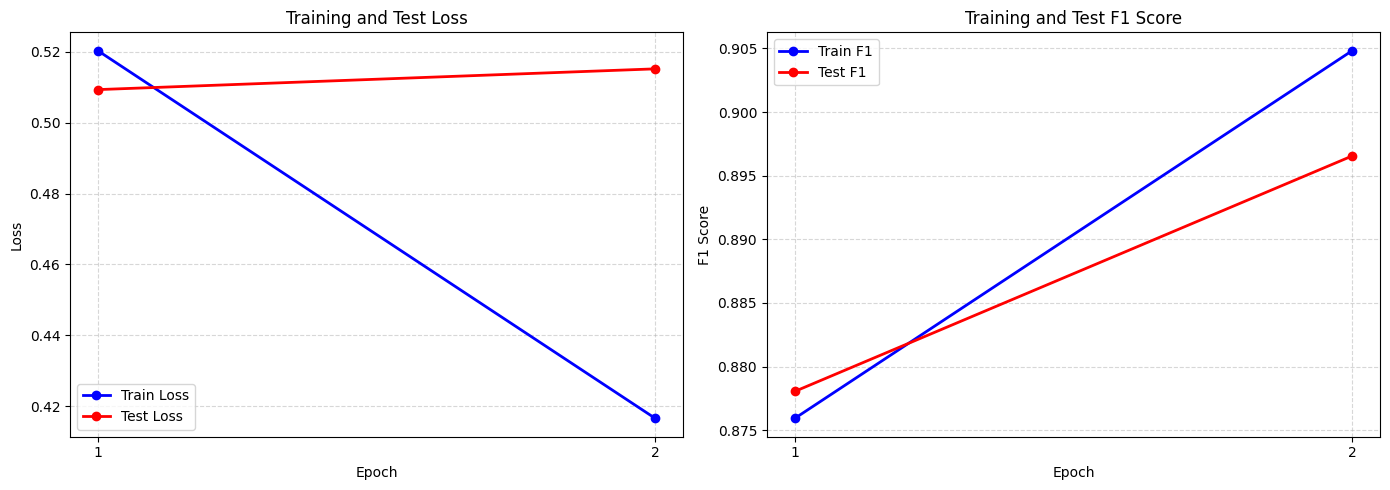

✅ Chart saved as stance_model_MT1_Bert_E8_B4_solveSample.pt_charts.png

Confusion Matrix:
[[ 7 18]
 [ 3 91]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.28      0.40        25
           1       0.83      0.97      0.90        94

    accuracy                           0.82       119
   macro avg       0.77      0.62      0.65       119
weighted avg       0.81      0.82      0.79       119

✅ Evaluation report saved as stance_model_MT1_Bert_E8_B4_solveSample.pt_eval.txt


In [36]:
plot_training_history_cm_cr(history,y_true=y_test,y_pred=y_test_pred, classes=["0", "1"], run_name='stance_model_MT1_Bert_E8_B4_solveSample.pt')


In [43]:
X_train_n, X_test_n, y_train_n, y_test_n = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [44]:
model_n, history_n, y_test_pred_n = train_model(
    X_train=(X_train_n['text'].tolist(), X_train_n['topic_id'].tolist()),
    y_train=y_train_n.tolist(),
    X_test=(X_test_n['text'].tolist(), X_test_n['topic_id'].tolist()),
    y_test=y_test_n.tolist(),
    batch_size=4,
    epochs=2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./models/Bert_stance_MT1_B4_E8_solveSmaple.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/2: 100%|██████████| 115/115 [04:26<00:00,  2.32s/it]



Epoch 1/2
Train Loss: 0.5397, Train F1: 0.8753
Test Loss: 0.5865, F1: 0.8571, Precision: 0.7500, Recall: 1.0000
--------------------------------------------------


Epoch 2/2: 100%|██████████| 115/115 [04:17<00:00,  2.24s/it]



Epoch 2/2
Train Loss: 0.4836, Train F1: 0.8897
Test Loss: 0.4286, F1: 0.8995, Precision: 0.8333, Recall: 0.9770
--------------------------------------------------
✅ Full model checkpoint saved to: ./models/Bert_stance_MT1_B4_E8_solveSmaple.pt


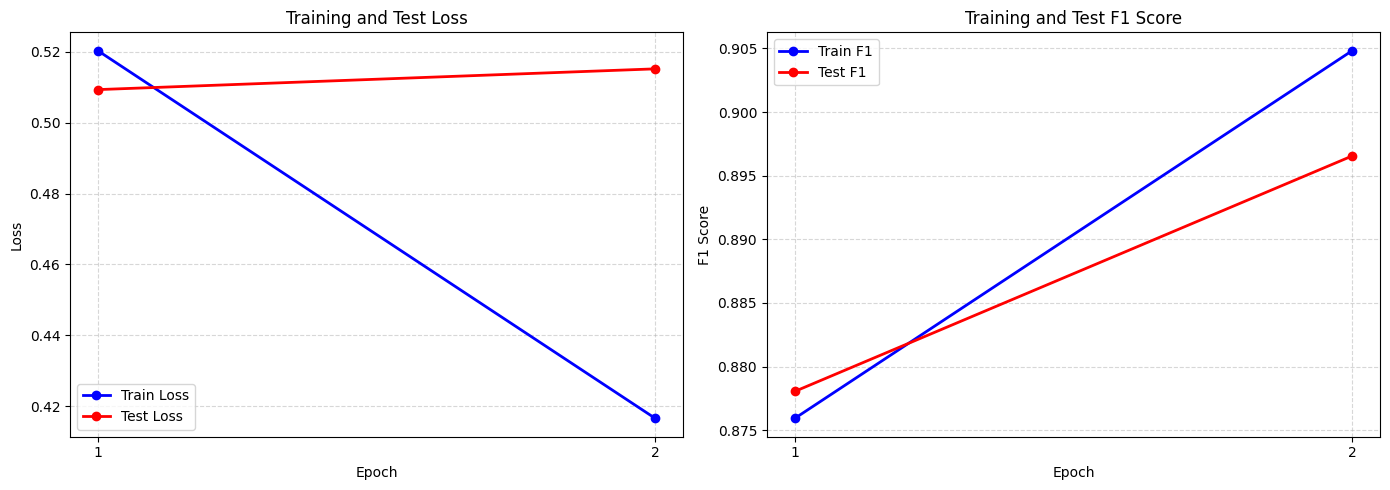

✅ Chart saved as Bert_stance_MT1_B4_E8_solveSmaple.pt_charts.png

Confusion Matrix:
[[ 7 18]
 [ 3 91]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.28      0.40        25
           1       0.83      0.97      0.90        94

    accuracy                           0.82       119
   macro avg       0.77      0.62      0.65       119
weighted avg       0.81      0.82      0.79       119

✅ Evaluation report saved as Bert_stance_MT1_B4_E8_solveSmaple.pt_eval.txt


In [45]:
plot_training_history_cm_cr(history,y_true=y_test,y_pred=y_test_pred, classes=["0", "1"], run_name='Bert_stance_MT1_B4_E8_solveSmaple.pt')


# Test Expand NRC Adapter

# MT1

In [52]:
X_tr, X_val, y_tr, y_val = preprocess_with_expandnrc(
        dfMT1,
        "./models/nrc_en.json",   #is the same?
        test_size=0.2,
        random_state=42,
        sample_level=False,
        device='cpu',
        threshold=0.6
    )
print("continue with training")

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


Computing ExpandNRC features (val): 100%|██████████| 116/116 [12:39<00:00,  6.54s/it]

continue with training


In [53]:
model, history, y_test_pred = train_model((X_tr['text'].tolist(), X_tr['topic_id'].tolist(),
        X_tr['expnrc_feats'].tolist()),
        y_tr,
        (X_val['text'].tolist(), X_val['topic_id'].tolist(),
         X_val['expnrc_feats'].tolist()),
        y_val,
        sample_level=False,
        batch_size=4,
        epochs=8,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_name='bert-base-uncased', 
        saved_model_path='./final_results/Bert_stance_MT1_B4_E8_eNRC.pt')

Computing ExpandNRC features (train):   0%|          | 0/44 [21:52:13<?, ?it/s]
h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 115/115 [10:53<00:00,  5.68s/it]



Epoch 1/8
Train Loss: 0.5497, Train F1: 0.8628
Test Loss: 0.4735, F1: 0.8952, Precision: 0.8103, Recall: 1.0000
--------------------------------------------------


Epoch 2/8: 100%|██████████| 115/115 [10:39<00:00,  5.56s/it]



Epoch 2/8
Train Loss: 0.4199, Train F1: 0.8954
Test Loss: 0.4697, F1: 0.9064, Precision: 0.8440, Recall: 0.9787
--------------------------------------------------


Epoch 3/8: 100%|██████████| 115/115 [05:18<00:00,  2.77s/it]



Epoch 3/8
Train Loss: 0.2539, Train F1: 0.9560
Test Loss: 0.5553, F1: 0.8995, Precision: 0.8947, Recall: 0.9043
--------------------------------------------------


Epoch 4/8: 100%|██████████| 115/115 [05:44<00:00,  3.00s/it]



Epoch 4/8
Train Loss: 0.1275, Train F1: 0.9792
Test Loss: 0.7045, F1: 0.9072, Precision: 0.8800, Recall: 0.9362
--------------------------------------------------


Epoch 5/8: 100%|██████████| 115/115 [05:46<00:00,  3.02s/it]



Epoch 5/8
Train Loss: 0.0536, Train F1: 0.9944
Test Loss: 0.7799, F1: 0.9053, Precision: 0.8958, Recall: 0.9149
--------------------------------------------------


Epoch 6/8: 100%|██████████| 115/115 [05:29<00:00,  2.86s/it]



Epoch 6/8
Train Loss: 0.0519, Train F1: 0.9944
Test Loss: 0.7931, F1: 0.9137, Precision: 0.8738, Recall: 0.9574
--------------------------------------------------


Epoch 7/8: 100%|██████████| 115/115 [05:37<00:00,  2.94s/it]



Epoch 7/8
Train Loss: 0.0281, Train F1: 0.9944
Test Loss: 0.8632, F1: 0.9137, Precision: 0.8738, Recall: 0.9574
--------------------------------------------------


Epoch 8/8: 100%|██████████| 115/115 [04:46<00:00,  2.49s/it]



Epoch 8/8
Train Loss: 0.0384, Train F1: 0.9944
Test Loss: 0.8195, F1: 0.9128, Precision: 0.8812, Recall: 0.9468
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/Bert_stance_MT1_B4_E8_eNRC.pt


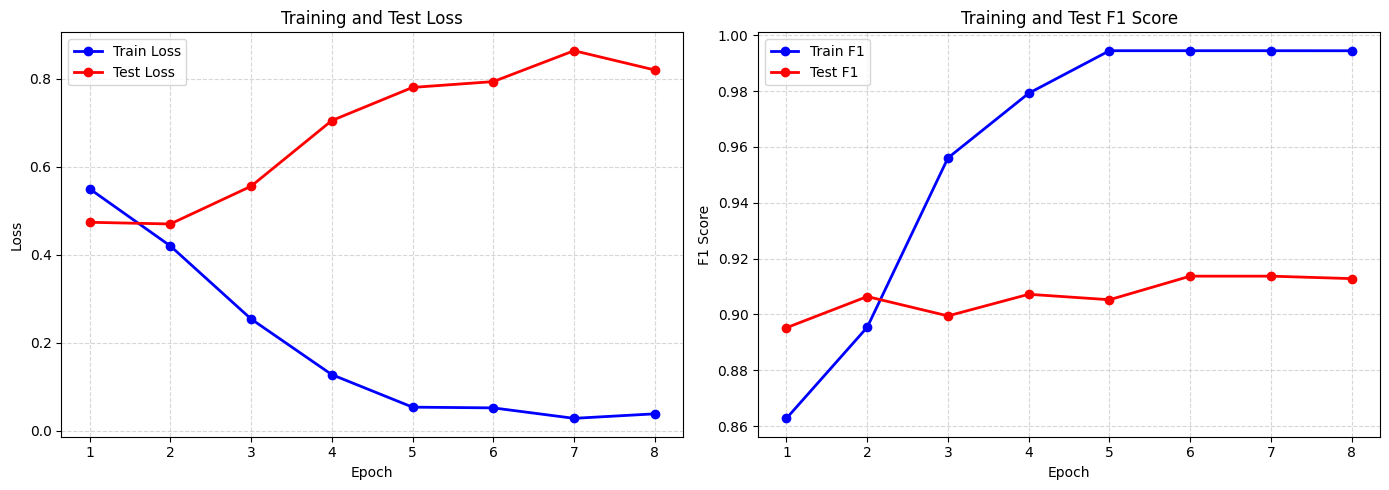

✅ Chart saved as ./final_results/Bert_stance_MT1_B4_E8_eNRC_charts.png

Confusion Matrix:
[[10 12]
 [ 5 89]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.45      0.54        22
           1       0.88      0.95      0.91        94

    accuracy                           0.85       116
   macro avg       0.77      0.70      0.73       116
weighted avg       0.84      0.85      0.84       116

✅ Evaluation report saved as ./final_results/Bert_stance_MT1_B4_E8_eNRC_eval.txt


In [54]:
plot_training_history_cm_cr(
    history,
    y_true=y_val,
    y_pred=y_test_pred,
    run_name="./final_results/Bert_stance_MT1_B4_E8_eNRC")

# MT2

In [55]:
X_tr, X_val, y_tr, y_val = preprocess_with_expandnrc(
        dfMT2,
        "./models/nrc_en.json",   #is the same?
        test_size=0.2,
        random_state=42,
        sample_level=False,
        device='cpu',
        threshold=0.6
    )
print("continue with training")

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


Computing ExpandNRC features (val): 100%|██████████| 160/160 [05:38<00:00,  2.11s/it]

continue with training


In [57]:
model, history, y_test_pred = train_model((X_tr['text'].tolist(), X_tr['topic_id'].tolist(),
        X_tr['expnrc_feats'].tolist()),
        y_tr,
        (X_val['text'].tolist(), X_val['topic_id'].tolist(),
         X_val['expnrc_feats'].tolist()),
        y_val,
        sample_level=False,
        batch_size=4,
        epochs=8,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_name='bert-base-uncased', 
        saved_model_path='./final_results/Bert_stance_MT2_B4_E8_eNRC.pt')

h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 160/160 [06:02<00:00,  2.27s/it]



Epoch 1/8
Train Loss: 0.4365, Train F1: 0.9197
Test Loss: 0.4019, F1: 0.9226, Precision: 0.8562, Recall: 1.0000
--------------------------------------------------


Epoch 2/8: 100%|██████████| 160/160 [05:59<00:00,  2.25s/it]



Epoch 2/8
Train Loss: 0.3831, Train F1: 0.9330
Test Loss: 0.4409, F1: 0.9347, Precision: 0.8831, Recall: 0.9927
--------------------------------------------------


Epoch 3/8: 100%|██████████| 160/160 [06:11<00:00,  2.32s/it]



Epoch 3/8
Train Loss: 0.3245, Train F1: 0.9504
Test Loss: 0.4307, F1: 0.9375, Precision: 0.8940, Recall: 0.9854
--------------------------------------------------


Epoch 4/8: 100%|██████████| 160/160 [07:26<00:00,  2.79s/it]



Epoch 4/8
Train Loss: 0.2036, Train F1: 0.9691
Test Loss: 0.6878, F1: 0.8582, Precision: 0.9032, Recall: 0.8175
--------------------------------------------------


Epoch 5/8: 100%|██████████| 160/160 [07:40<00:00,  2.88s/it]



Epoch 5/8
Train Loss: 0.1231, Train F1: 0.9793
Test Loss: 0.7035, F1: 0.9268, Precision: 0.8867, Recall: 0.9708
--------------------------------------------------


Epoch 6/8: 100%|██████████| 160/160 [06:36<00:00,  2.48s/it]



Epoch 6/8
Train Loss: 0.0514, Train F1: 0.9910
Test Loss: 0.8319, F1: 0.9247, Precision: 0.8710, Recall: 0.9854
--------------------------------------------------


Epoch 7/8: 100%|██████████| 160/160 [06:35<00:00,  2.47s/it]



Epoch 7/8
Train Loss: 0.0015, Train F1: 1.0000
Test Loss: 0.7808, F1: 0.9371, Precision: 0.8993, Recall: 0.9781
--------------------------------------------------


Epoch 8/8: 100%|██████████| 160/160 [06:33<00:00,  2.46s/it]



Epoch 8/8
Train Loss: 0.0009, Train F1: 1.0000
Test Loss: 0.8292, F1: 0.9371, Precision: 0.8993, Recall: 0.9781
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/Bert_stance_MT2_B4_E8_eNRC.pt


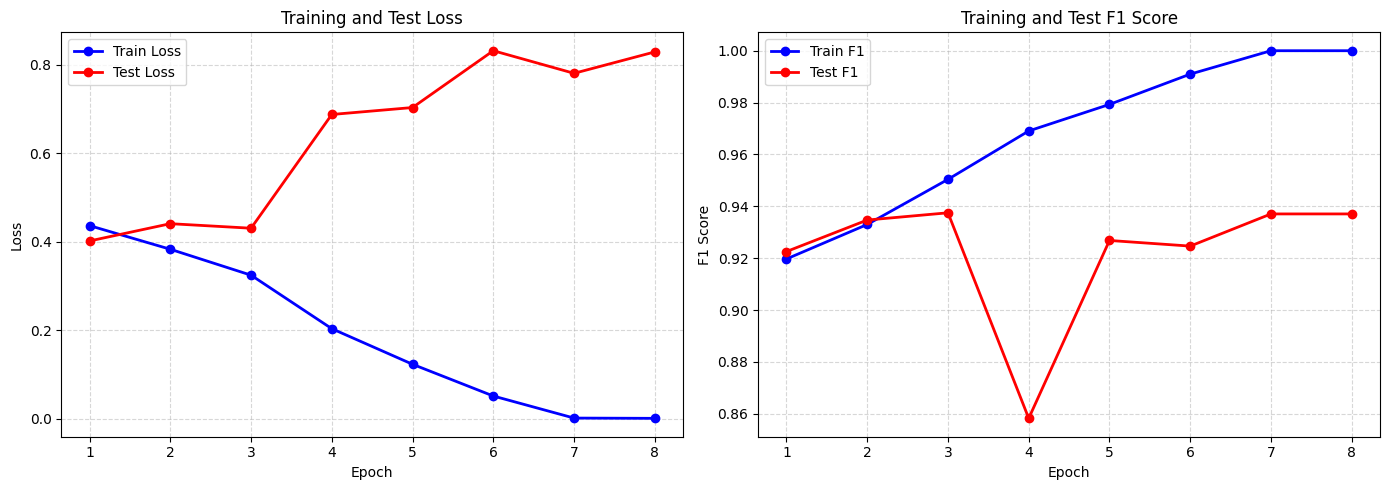

✅ Chart saved as ./final_results/Bert_stance_MT2_B4_E8_eNRC_charts.png

Confusion Matrix:
[[  8  15]
 [  3 134]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.35      0.47        23
           1       0.90      0.98      0.94       137

    accuracy                           0.89       160
   macro avg       0.81      0.66      0.70       160
weighted avg       0.87      0.89      0.87       160

✅ Evaluation report saved as ./final_results/Bert_stance_MT2_B4_E8_eNRC_eval.txt


In [58]:
plot_training_history_cm_cr(
    history,
    y_true=y_val,
    y_pred=y_test_pred,
    run_name="./final_results/Bert_stance_MT2_B4_E8_eNRC")

In [ ]:
model, history, y_test_pred = train_model((X_tr['text'].tolist(), X_tr['topic_id'].tolist(),
        X_tr['expnrc_feats'].tolist()),
        y_tr,
        (X_val['text'].tolist(), X_val['topic_id'].tolist(),
         X_val['expnrc_feats'].tolist()),
        y_val,
        sample_level=False,
        batch_size=4,
        epochs=8,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_name='bert-base-uncased', 
        saved_model_path='./final_results/Bert_stance_MT2_B4_E8_eNRC.pt')

### IBM

In [3]:

X_tr, X_val, y_tr, y_val = preprocess_with_expandnrc(
        dfIBM,
        "./models/nrc_en.json",   #is the same?
        test_size=0.2,
        random_state=42,
        sample_level=False,
        device='cpu',
        threshold=0.6
    )
print("continue with training")
    

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


Computing ExpandNRC features (val): 100%|██████████| 479/479 [11:37<00:00,  1.46s/it]

continue with training


In [ ]:
model, history, y_test_pred = train_model((X_tr['text'].tolist(), X_tr['topic_id'].tolist(),
        X_tr['expnrc_feats'].tolist()),
        y_tr,
        (X_val['text'].tolist(), X_val['topic_id'].tolist(),
         X_val['expnrc_feats'].tolist()),
        y_val,
        sample_level=False,
        batch_size=4,
        epochs=8,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_name='bert-base-uncased', 
        saved_model_path='./final_results/Bert_stance_IBM_B4_E8_eNRC.pt'    #saving problem, done
    )

h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 479/479 [18:49<00:00,  2.36s/it]



Epoch 1/8
Train Loss: 0.6929, Train F1: 0.6225
Test Loss: 0.6484, F1: 0.7392, Precision: 0.6442, Recall: 0.8671
--------------------------------------------------


Epoch 2/8: 100%|██████████| 479/479 [17:35<00:00,  2.20s/it]



Epoch 2/8
Train Loss: 0.6564, Train F1: 0.6636
Test Loss: 0.6373, F1: 0.7477, Precision: 0.6553, Recall: 0.8706
--------------------------------------------------


Epoch 3/8: 100%|██████████| 479/479 [16:14<00:00,  2.03s/it]



Epoch 3/8
Train Loss: 0.5306, Train F1: 0.8017
Test Loss: 0.8686, F1: 0.7185, Precision: 0.7638, Recall: 0.6783
--------------------------------------------------


Epoch 4/8: 100%|██████████| 479/479 [17:08<00:00,  2.15s/it]



Epoch 4/8
Train Loss: 0.4101, Train F1: 0.8917
Test Loss: 1.0391, F1: 0.7714, Precision: 0.7064, Recall: 0.8497
--------------------------------------------------


Epoch 5/8: 100%|██████████| 479/479 [17:30<00:00,  2.19s/it]



Epoch 5/8
Train Loss: 0.2489, Train F1: 0.9470
Test Loss: 1.5934, F1: 0.6863, Precision: 0.7812, Recall: 0.6119
--------------------------------------------------


Epoch 6/8: 100%|██████████| 479/479 [18:28<00:00,  2.31s/it]



Epoch 6/8
Train Loss: 0.1674, Train F1: 0.9661
Test Loss: 1.6306, F1: 0.7638, Precision: 0.6803, Recall: 0.8706
--------------------------------------------------


Epoch 7/8: 100%|██████████| 479/479 [18:53<00:00,  2.37s/it]



Epoch 7/8
Train Loss: 0.1114, Train F1: 0.9760
Test Loss: 1.7314, F1: 0.7819, Precision: 0.7051, Recall: 0.8776
--------------------------------------------------


Epoch 8/8: 100%|██████████| 479/479 [19:11<00:00,  2.40s/it]



Epoch 8/8
Train Loss: 0.1148, Train F1: 0.9784
Test Loss: 2.0465, F1: 0.7083, Precision: 0.7727, Recall: 0.6538
--------------------------------------------------
✅ Full model checkpoint saved to: ./models/Bert_stance_MT1_B4_E8_eNRC.pt


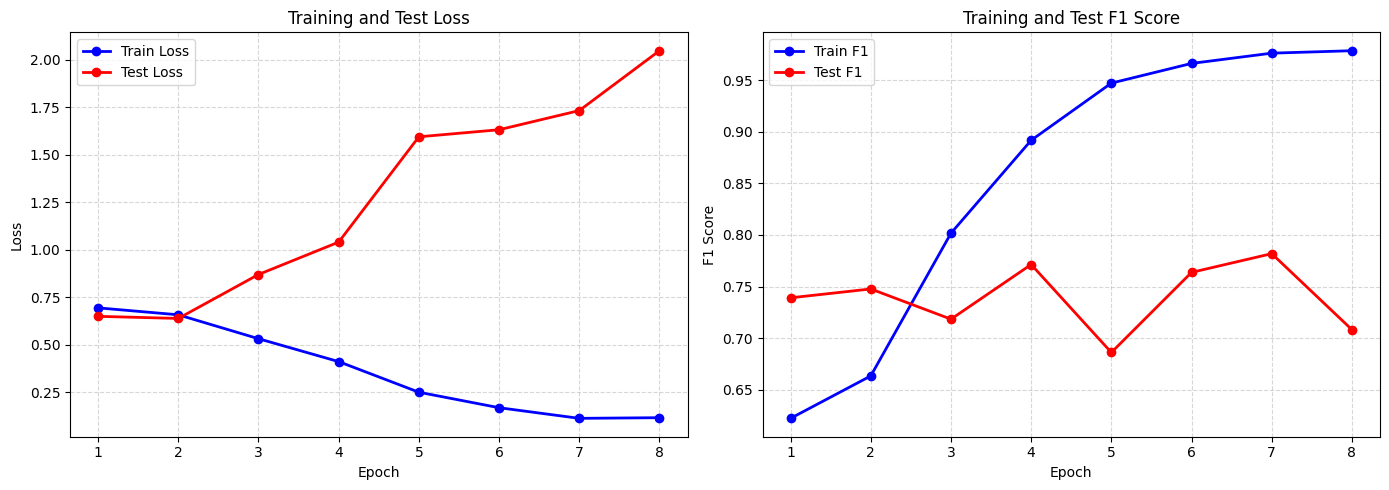

✅ Chart saved as ./models/Bert_stance_IBM_B4_E8_eNRC.pt_charts.png

Confusion Matrix:
[[138  55]
 [ 99 187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       193
           1       0.77      0.65      0.71       286

    accuracy                           0.68       479
   macro avg       0.68      0.68      0.68       479
weighted avg       0.70      0.68      0.68       479

✅ Evaluation report saved as ./models/Bert_stance_IBM_B4_E8_eNRC.pt_eval.txt


In [5]:
plot_training_history_cm_cr(
    history,
    y_true=y_val,
    y_pred=y_test_pred,
    run_name="./models/Bert_stance_IBM_B4_E8_eNRC.pt"
)

# UKB

In [6]:
dfUKB['stance'] = dfUKB['stance'].apply(
    lambda stance_list: ['Neutral' if s is None else s for s in stance_list])

In [ ]:
X_tr_s, X_val_s, y_tr_s, y_val_s = preprocess_with_expandnrc(
        dfUKB,
        "./models/nrc_en.json",  
        test_size=0.2,
        random_state=42,
        sample_level= False,
        device='cpu',
        threshold=0.6
    )
print("continue with training")

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


In [ ]:
model, history, y_test_pred = train_model((X_tr['text'].tolist(), X_tr['topic_id'].tolist(),
        X_tr['expnrc_feats'].tolist()),
        y_tr,
        (X_val['text'].tolist(), X_val['topic_id'].tolist(),
         X_val['expnrc_feats'].tolist()),
        y_val,
        sample_level=False,
        batch_size=4,
        epochs=8,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_name='bert-base-uncased', 
        saved_model_path='./final_results/Bert_stance_UKB_B4_E8_eNRC.pt'    #saving problem, done
    )

NameError: name 'train_model' is not defined

In [ ]:
plot_training_history_cm_cr(
    history,
    y_true=y_val,
    y_pred=y_test_pred,
    run_name="./models/Bert_stance_UKB_B4_E8_eNRC.pt"
)

# Smaple Ture (Error)

In [ ]:

X_tr_s, X_val_s, y_tr_s, y_val_s = preprocess_with_expandnrc(
        dfIBM,
        "./models/nrc_en.json",  
        test_size=0.2,
        random_state=42,
        sample_level= True,
        device='cpu',
        threshold=0.6
    )
print("continue with training")

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'list'>

# PE

In [48]:
X_tr, X_val, y_tr, y_val = preprocess_with_expandnrc(
        dfPC,
        "./models/nrc_en.json",   #is the same?
        test_size=0.2,
        random_state=42,
        sample_level=False,
        device='cpu',
        threshold=0.6
    )
print("continue with training")
    

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl



Computing ExpandNRC features (train):   0%|          | 0/44 [06:06<?, ?it/s]




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































continue with training


In [ ]:
model, history, y_test_pred = train_model((X_tr['text'].tolist(), X_tr['topic_id'].tolist(),
        X_tr['expnrc_feats'].tolist()),
        y_tr,
        (X_val['text'].tolist(), X_val['topic_id'].tolist(),
         X_val['expnrc_feats'].tolist()),
        y_val,
        sample_level=False,
        batch_size=4,
        epochs=8,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_name='bert-base-uncased', 
        saved_model_path='./final_results/Bert_stance_PE_B4_E8_eNRC.pt'
    )

h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 1218/1218 [54:13<00:00,  2.67s/it] 



Epoch 1/8
Train Loss: 0.6902, Train F1: 0.2906
Test Loss: 0.7978, F1: 0.2878, Precision: 0.2531, Recall: 0.3333
--------------------------------------------------


Epoch 2/8: 100%|██████████| 1218/1218 [54:24<00:00,  2.68s/it] 



Epoch 2/8
Train Loss: 0.6705, Train F1: 0.3762
Test Loss: 0.7275, F1: 0.3115, Precision: 0.3703, Recall: 0.3418
--------------------------------------------------


Epoch 3/8: 100%|██████████| 1218/1218 [52:56<00:00,  2.61s/it]



Epoch 3/8
Train Loss: 0.5832, Train F1: 0.4931
Test Loss: 1.0246, F1: 0.3941, Precision: 0.3846, Recall: 0.4049
--------------------------------------------------


Epoch 4/8: 100%|██████████| 1218/1218 [48:31<00:00,  2.39s/it]



Epoch 4/8
Train Loss: 0.4251, Train F1: 0.6547
Test Loss: 1.2798, F1: 0.4351, Precision: 0.5080, Recall: 0.4175
--------------------------------------------------


Epoch 5/8: 100%|██████████| 1218/1218 [48:46<00:00,  2.40s/it]



Epoch 5/8
Train Loss: 0.3029, Train F1: 0.7930
Test Loss: 1.7361, F1: 0.4458, Precision: 0.5456, Recall: 0.4380
--------------------------------------------------


Epoch 6/8: 100%|██████████| 1218/1218 [48:41<00:00,  2.40s/it]



Epoch 6/8
Train Loss: 0.2069, Train F1: 0.8731
Test Loss: 1.8173, F1: 0.4457, Precision: 0.4708, Recall: 0.4323
--------------------------------------------------


Epoch 7/8: 100%|██████████| 1218/1218 [48:58<00:00,  2.41s/it]



Epoch 7/8
Train Loss: 0.1418, Train F1: 0.9165
Test Loss: 2.1124, F1: 0.4422, Precision: 0.4646, Recall: 0.4340
--------------------------------------------------


Epoch 8/8: 100%|██████████| 1218/1218 [48:42<00:00,  2.40s/it]



Epoch 8/8
Train Loss: 0.1022, Train F1: 0.9464
Test Loss: 2.5719, F1: 0.4204, Precision: 0.4292, Recall: 0.4145
--------------------------------------------------
✅ Full model checkpoint saved to: ./models/Bert_stance_PE_B4_E8_eNRC.pt


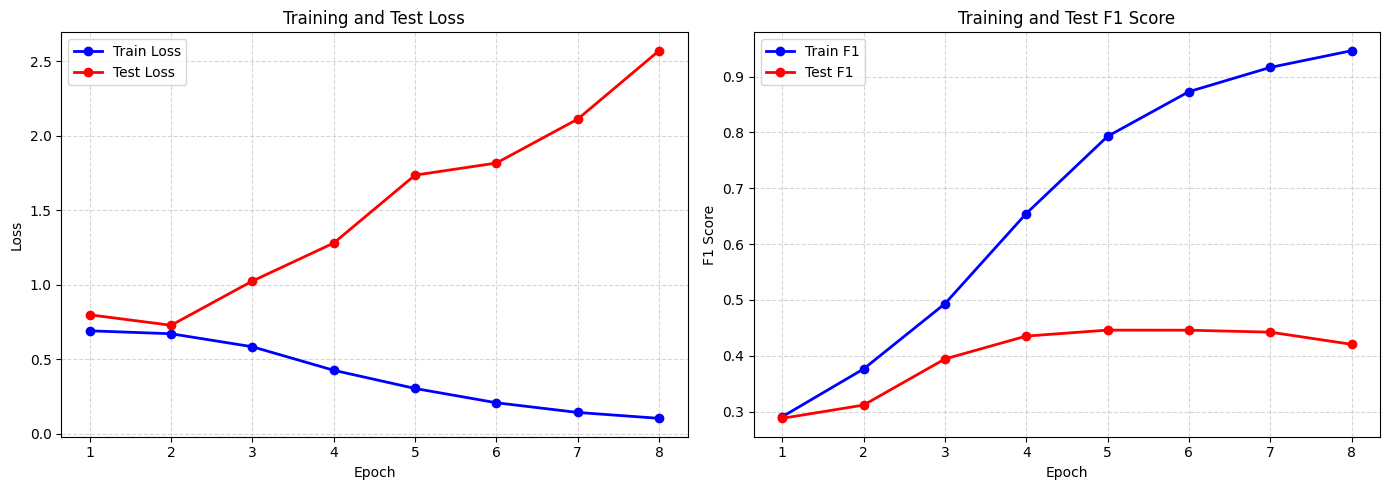

✅ Chart saved as ./models/Bert_stance_PE_B4_E8_eNRC.pt_charts.png

Confusion Matrix:
[[  6   9  32]
 [  6  74 166]
 [ 22 149 754]]

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.13      0.15        47
           1       0.32      0.30      0.31       246
           2       0.79      0.82      0.80       925

    accuracy                           0.68      1218
   macro avg       0.43      0.41      0.42      1218
weighted avg       0.67      0.68      0.68      1218

✅ Evaluation report saved as ./models/Bert_stance_PE_B4_E8_eNRC.pt_eval.txt


In [ ]:
plot_training_history_cm_cr(
    history,
    y_true=y_val,
    y_pred=y_test_pred,
    run_name=".//Bert_stance_PE_B4_E8_eNRC.pt"
)

In [ ]:

X_tr, X_val, y_tr, y_val = preprocess_with_expandnrc(
        dfPC,
        "./models/nrc_en.json",   #is the same?
        test_size=0.2,
        random_state=42,
        sample_level=False,
        device='cpu',
        threshold=0.6
    )
print("continue with training")